# Import modules

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Extract data

In [2]:
os.listdir('C:\\Users\\boonkiat\\Downloads\\cell_images')

['test', 'train']

In [3]:
my_dir = 'C:\\Users\\boonkiat\\Downloads\\cell_images'

In [4]:
train_path = my_dir + '\\train'

In [5]:
test_path = my_dir + '\\test'

In [8]:
para_cell = train_path + '\\parasitized\\' + os.listdir(train_path + '\\parasitized\\')[0]

In [11]:
para_img = plt.imread(para_cell)

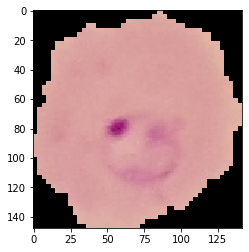

In [12]:
plt.imshow(para_img)

In [14]:
uninfected_cell = train_path + '\\uninfected\\' + os.listdir(train_path + '\\uninfected')[0]

In [15]:
uninfected_img = plt.imread(uninfected_cell)

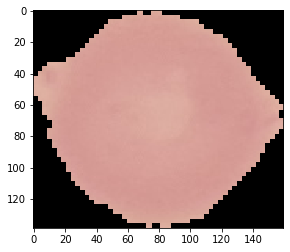

In [16]:
plt.imshow(uninfected_img)

# Find the average dimensions

In [29]:
dim1, dim2 = [], []

In [30]:
for image in os.listdir(test_path + '\\uninfected'):
    img = plt.imread(test_path + '\\uninfected\\' + image)
    dim1.append(img.shape[0])
    dim2.append(img.shape[1])
    

In [32]:
np.mean(dim1)

130.92538461538462

In [33]:
np.mean(dim2)

130.75

In [34]:
image_shape = (130, 130, 3)

# Preparing the Data for the Model

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
img_gen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             fill_mode='nearest',
                             horizontal_flip=True,
                             rescale=1/255)

In [37]:
img_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


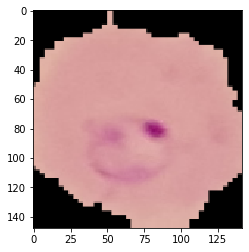

In [38]:
plt.imshow(img_gen.random_transform(para_img))


In [39]:
batch_size = 16

In [40]:
train_img_gen = img_gen.flow_from_directory(directory=train_path,
                                            target_size=image_shape[0:2],
                                            color_mode='rgb',
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=True)

Found 24958 images belonging to 2 classes.


In [41]:
test_img_gen = img_gen.flow_from_directory(directory=test_path,
                                           target_size=image_shape[0:2],
                                           color_mode='rgb',
                                           class_mode='binary',
                                           batch_size=batch_size,
                                           shuffle=False)

Found 2600 images belonging to 2 classes.


# Creating a model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [43]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

# Early Stopping

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Training the Model

In [47]:
model.fit(train_img_gen, validation_data=test_img_gen, epochs=5, callbacks=[early_stop])

Epoch 1/5
1560/1560 [==============================] - 444s 284ms/step - loss: 0.3606 - val_loss: 0.1815
Epoch 2/5
1560/1560 [==============================] - 446s 286ms/step - loss: 0.1799 - val_loss: 0.1774
Epoch 3/5
1560/1560 [==============================] - 455s 292ms/step - loss: 0.1730 - val_loss: 0.1666
Epoch 4/5
1560/1560 [==============================] - 584s 374ms/step - loss: 0.1658 - val_loss: 0.1677
Epoch 5/5
1560/1560 [==============================] - 613s 393ms/step - loss: 0.1619 - val_loss: 0.1572


In [48]:
# model.save('CNN_test_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN_test_model\assets


In [81]:
from tensorflow.keras.models import load_model
model = load_model('CNN_test_model')


# Evaluating the Model

In [52]:
# losses = pd.DataFrame(model.history.history)

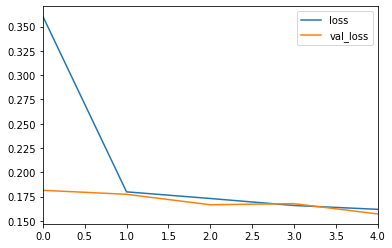

In [53]:
# losses[['loss', 'val_loss']].plot()

In [82]:
model.metrics_names

['loss']

In [83]:
model.evaluate(test_img_gen)

163/163 [==============================] - 37s 229ms/step - loss: 0.1615


0.16151337325572968

In [56]:
from tensorflow.keras.preprocessing import image

In [57]:
pred_probabilities = model.predict(test_img_gen)

In [58]:
test_img_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [59]:
predictions = pred_probabilities > 0.5

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
print(classification_report(test_img_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1300
           1       0.93      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [65]:
confusion_matrix(test_img_gen.classes, predictions)

array([[1207,   93],
       [  42, 1258]], dtype=int64)

# Predicting on an Image

In [ ]:
# Transform image into numpy array with the right dimensions

In [72]:
my_image = image.load_img(para_cell, target_size=image_shape[0:2])

In [73]:
my_image = image.img_to_array(my_image)

In [74]:
my_image = np.expand_dims(my_image, axis=0)

In [75]:
my_image.shape

(1, 130, 130, 3)

In [76]:
# predict

In [77]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [79]:
train_img_gen.class_indices

{'parasitized': 0, 'uninfected': 1}